# Transformers

This notebook is a supplement to the Transformers Chapter of the [Hands-On Generative AI with Transformers and Diffusion Models](https://learning.oreilly.com/library/view/hands-on-generative-ai/9781098149239/) book. This notebooks includes:

* The code from the book
* Additional examples
* Exercise solutions.

In [17]:
from transformers import logging

logging.set_verbosity_error()

## A Language Model in Action

### Tokenizing Text

In [1]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")
input_ids = tokenizer("It was a dark and stormy", return_tensors="pt").input_ids
input_ids

tensor([[1026,  373,  257, 3223,  290, 6388,   88]])

In [2]:
for t in input_ids[0]:
    print(t, "\t:", tokenizer.decode(t))

tensor(1026) 	: It
tensor(373) 	:  was
tensor(257) 	:  a
tensor(3223) 	:  dark
tensor(290) 	:  and
tensor(6388) 	:  storm
tensor(88) 	: y


### Predicting Probabilities

In [4]:
from transformers import AutoModelForCausalLM

gpt2 = AutoModelForCausalLM.from_pretrained("gpt2")

In [5]:
outputs = gpt2(input_ids)
outputs.logits.shape  # An output for each input token

torch.Size([1, 7, 50257])

In [6]:
final_logits = gpt2(input_ids).logits[0, -1]  # The last set of logits
final_logits.argmax()  # The position of the maximum

tensor(1755)

In [7]:
tokenizer.decode(final_logits.argmax())

' night'

In [8]:
import torch

top10_logits = torch.topk(final_logits, 10)
for index in top10_logits.indices:
    print(tokenizer.decode(index))

 night
 day
 evening
 morning
 afternoon
 summer
 time
 winter
 weekend
,


In [9]:
top10 = torch.topk(final_logits.softmax(dim=0), 10)
for value, index in zip(top10.values, top10.indices):
    print(f"{tokenizer.decode(index):<10} {value.item():.2%}")

 night     46.18%
 day       23.46%
 evening   5.87%
 morning   4.42%
 afternoon 4.11%
 summer    1.34%
 time      1.33%
 winter    1.22%
 weekend   0.39%
,          0.38%


### Generating Text

**Greedy Decoding**

In [18]:
output_ids = gpt2.generate(input_ids, max_new_tokens=20)
decoded_text = tokenizer.decode(output_ids[0])

print("Input IDs", input_ids[0])
print("Output IDs", output_ids)
print(f"Generated text: {decoded_text}")

Input IDs tensor([1026,  373,  257, 3223,  290, 6388,   88])
Output IDs tensor([[ 1026,   373,   257,  3223,   290,  6388,    88,  1755,    13,   383,
          2344,   373, 19280,    11,   290,   262, 15114,   547,  7463,    13,
           383,  2344,   373, 19280,    11,   290,   262]])
Generated text: It was a dark and stormy night. The wind was blowing, and the clouds were falling. The wind was blowing, and the


**Beam Search**

In [19]:
beam_output = gpt2.generate(
    input_ids,
    num_beams=5,
    max_new_tokens=30,
)

print(tokenizer.decode(beam_output[0], skip_special_tokens=True))

It was a dark and stormy night.

"It was dark and stormy," he said.

"It was dark and stormy," he said.




**Beam search with repetition penalty**

In [20]:
beam_output = gpt2.generate(
    input_ids,
    num_beams=5,
    repetition_penalty=1.2,
    max_new_tokens=38,
)

print(tokenizer.decode(beam_output[0], skip_special_tokens=True))

It was a dark and stormy night.

"There was a lot of rain," he said. "It was very cold."

He said he saw a man with a gun in his hand.




**Sampling**

In [21]:
from transformers import set_seed

# Setting the seed ensures we get the same results every time we run this code
set_seed(70)

sampling_output = gpt2.generate(
    input_ids,
    do_sample=True,
    max_length=34,
    top_k=0,  # We'll come back to this parameter
)

print(tokenizer.decode(sampling_output[0], skip_special_tokens=True))

It was a dark and stormy day until it broke down the big canvas on my sleep station, making me money dilapidated, and, with a big soothing mug


**Sampling with different `temperature`s**

In [22]:
sampling_output = gpt2.generate(
    input_ids,
    do_sample=True,
    temperature=0.4,
    max_length=40,
    top_k=0,
)

print(tokenizer.decode(sampling_output[0], skip_special_tokens=True))

It was a dark and stormy night, and I was alone. I was in the middle of the night, and I was suddenly awakened bygoodness, and I was thinking of the old man


In [23]:
sampling_output = gpt2.generate(
    input_ids,
    do_sample=True,
    temperature=0.001,
    max_length=40,
    top_k=0,
)

print(tokenizer.decode(sampling_output[0], skip_special_tokens=True))

It was a dark and stormy night. The wind was blowing, and the clouds were falling. The wind was blowing, and the clouds were falling. The wind was blowing, and the clouds were


In [25]:
sampling_output = gpt2.generate(
    input_ids,
    do_sample=True,
    temperature=3.0,
    max_length=40,
    top_k=0,
)

print(tokenizer.decode(sampling_output[0], skip_special_tokens=True))

It was a dark and stormy corporation street compliment ideallylake amended Churchill ty set crou 175 dualKing Bucc ceiling wrapped.......my tryhouse fragileREG Robinson lower display magn Simon spectral warmth HP274 Lur Welsh


**Sampling with `top_k`**

In [26]:
sampling_output = gpt2.generate(
    input_ids,
    do_sample=True,
    max_length=40,
    top_k=10,
)

print(tokenizer.decode(sampling_output[0], skip_special_tokens=True))

It was a dark and stormy night and I was not expecting to be here at 9:30 AM. It felt cold and rainy. I didn't know why I was here. There was no


**Top p sampling**

In [27]:
sampling_output = gpt2.generate(
    input_ids,
    do_sample=True,
    max_length=40,
    top_p=0.94,
    top_k=0,
)

print(tokenizer.decode(sampling_output[0], skip_special_tokens=True))

It was a dark and stormy hour, a formation of what looked like beggar to an armoire-upper of the home that flickered down the cobbled main road, leaned slowly against


### Zero-shot Classification

#### Book code

In [28]:
tokenizer.encode(" positive"), tokenizer.encode(" negative")

([3967], [4633])

In [30]:
def score(review):
    """Predict whether it is positive or negative

    This function predicts whether a review is positive or negative
    using a bit of clever prompting. It looks at the logits for the
    tokens ' positive' and ' negative' (note the space before the
    words), and returns the label with the highest score.
    """
    prompt = f"""Question: Is the following review positive or 
negative about the movie? 
Review: {review} Answer:"""

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids  # <1>
    final_logits = gpt2(input_ids).logits[0, -1]  # <2>
    if final_logits[3967] > final_logits[4633]:  # <3>
        print("Positive")
    else:  # <3>
        print("Negative")

In [31]:
score("This movie was terrible!")

Negative


In [32]:
score("That was a delight to watch, 10/10 would recommend :)")

Positive


In [33]:
score("A complex yet wonderful film about the depravity of man")  # A mistake

Negative


#### Suplementary material (not in the book)

This section shows how to use a pre-trained generative model to perform classification via zero-shot classification. We'll use a dataset of labeled reviews and measure the confusion matrix. A confusion matrix serves as a table summarizing a model's performance, depicting counts of true positive, true negative, false positive, and false negative predictions. Rows indicate actual (ground truth) classes, while columns indicate predicted classes. Analyzing this matrix provides insights into the model's strengths and weaknesses in distinguishing between specific classes.

Let's use the `gpt2` model and its tokenizer.

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("gpt2")
gpt2 = AutoModelForCausalLM.from_pretrained("gpt2").to(device)

Then, we define our `score` function just as in the book, but with some key differences:

* we use 1 (`positive`) and 0 (`negative`),
* we receive a sample so we can use the `datasets` library. You can use this as a dictionary with the review being accessible with `sample["text"]`,
* we add a new column, `pred`, which contains the 0 or 1 from the model.
* we add `truncation=True` to the `tokenizer` call. Truncation is needed as `score` will be called with a batch of samples, and we need to ensure that all samples have the same length. We'll explain in future chapters why this is needed, but for now, just remember that it's necessary when working with batches of samples.

In [34]:
def score(sample):
    """Given a review, predict whether it is positive or negative using a bit of clever prompting"""
    prompt = f"Question: Is the following review positive or negative about the movie? Review: {sample['text']} Answer:"
    input_ids = tokenizer(
        prompt, truncation=True, return_tensors="pt"
    ).input_ids.to(device)
    final_logits = gpt2(input_ids).logits[0, -1]
    if final_logits[3967] > final_logits[4633]:
        sample["pred"] = 1
    else:
        sample["pred"] = 0
    return sample

In [38]:
score({"text": "This movie was terrible!"})

{'text': 'This movie was terrible!', 'pred': 0}

Let's use the [IMDB](https://huggingface.co/datasets/imdb) dataset, which contains 25,000 rows of labeled reviews. We'll use the `datasets` library to load the dataset and load the `train` split.

In [39]:
from datasets import load_dataset

dataset = load_dataset("imdb")["train"]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

For fast iteration, we'll just use 1000 random samples from the dataset. We'll `shuffle` the dataset and then take the first 1000 samples.

In [41]:
shuffled_dataset = dataset.shuffle(seed=42)
small_dataset = shuffled_dataset.select(range(1000))

Then, we can use the `score` function to predict the sentiment of the reviews and compare the predictions with the actual labels.

In [42]:
updated_dataset = small_dataset.map(score)
updated_dataset

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'pred'],
    num_rows: 1000
})

We'll use the `evaluate` library to obtain the confusion matrix. A confusion matrix serves as a table summarizing a model's performance, depicing counts of true positive, true negatives, false positive, and false negative predictions. Rows indicate actual (label) classes, while columns indicate predicted classes. Analyzing this matrix provides insights into the model's strengths and weaknesses in distinguishing between classes. The fine-tune LLM chapter dives into this metric.

In [43]:
import evaluate

confusion_matrix = evaluate.load("confusion_matrix")
cm = confusion_matrix.compute(
    references=updated_dataset["label"],
    predictions=updated_dataset["pred"],
)
cm

{'confusion_matrix': array([[349, 163],
        [140, 348]])}

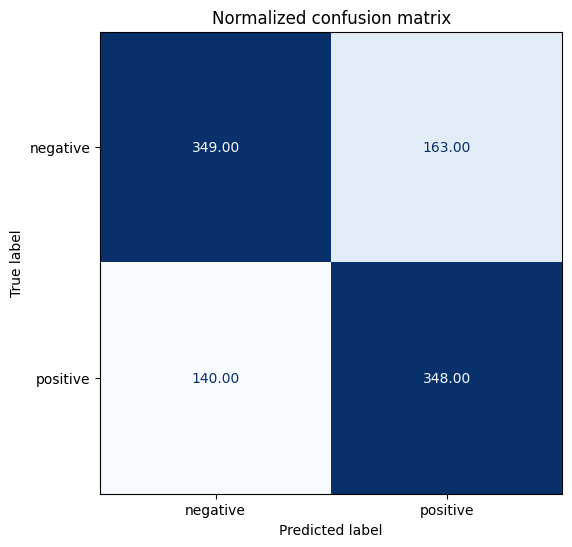

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm["confusion_matrix"],
    display_labels=["negative", "positive"],
)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)

plt.title("Normalized confusion matrix")
plt.show()

What do we get out of these results?

* The model does not perform amazingly well. There are many false negatives and false positives.
* The model performance seems about the same for both classes.

Finally, we can also convert the dataset to a Pandas `DataFrame` and explore the data directly. Here is a starting point

In [45]:
df = updated_dataset.to_pandas()
df.head()

,text,label,pred
0,There is no relation at all between Fortier an...,1,0
1,This movie is a great. The plot is very true t...,1,1
2,"George P. Cosmatos' ""Rambo: First Blood Part I...",0,0
3,In the process of trying to establish the audi...,1,1
4,"Yeh, I know -- you're quivering with excitemen...",0,1


**Now it's your turn**. Experiment with tweaking the prompt template to improve the model performance. What's the best confusion matrix you can achieve? What if you try another model?

### Few-Shot Generation

In [46]:
model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B")

In [47]:
prompt = """\
Translate English to Spanish:

English: I do not speak Spanish.
Spanish: No hablo español.

English: See you later!
Spanish: ¡Hasta luego!

English: Where is a good restaurant?
Spanish: ¿Dónde hay un buen restaurante?

English: What rooms do you have available?
Spanish: ¿Qué habitaciones tiene disponibles?

English: I like soccer
Spanish:"""
inputs = tokenizer(prompt, return_tensors="pt").input_ids
output = model.generate(
    inputs,
    do_sample=False,
    max_new_tokens=10,
)

print(tokenizer.decode(output[0], skip_special_tokens=True))

Translate English to Spanish:

English: I do not speak Spanish.
Spanish: No hablo español.

English: See you later!
Spanish: ¡Hasta luego!

English: Where is a good restaurant?
Spanish: ¿Dónde hay un buen restaurante?

English: What rooms do you have available?
Spanish: ¿Qué habitaciones tiene disponibles?

English: I like soccer
Spanish: Me gusta el fútbol




## Transformer Models Genealogy

### Encoder-only models

In [48]:
from transformers import pipeline

fill_masker = pipeline(model="bert-base-uncased")
fill_masker("The [MASK] is made of milk.")

/home/osanseviero/miniconda3/envs/book/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

[{'score': 0.19546684622764587,
  'token': 9841,
  'token_str': 'dish',
  'sequence': 'the dish is made of milk.'},
 {'score': 0.12907549738883972,
  'token': 8808,
  'token_str': 'cheese',
  'sequence': 'the cheese is made of milk.'},
 {'score': 0.10590682178735733,
  'token': 6501,
  'token_str': 'milk',
  'sequence': 'the milk is made of milk.'},
 {'score': 0.04112086817622185,
  'token': 4392,
  'token_str': 'drink',
  'sequence': 'the drink is made of milk.'},
 {'score': 0.03712357580661774,
  'token': 7852,
  'token_str': 'bread',
  'sequence': 'the bread is made of milk.'}]

## The Power of Pre-training

### The key Insights of Transformers


In [49]:
from transformers import pipeline

classifier = pipeline(model="distilbert-base-uncased-finetuned-sst-2-english")
classifier("This movie is disgustingly good !")

[{'label': 'POSITIVE', 'score': 0.9998536109924316}]

### Limitations


In [50]:
unmasker = pipeline("fill-mask", model="bert-base-uncased")
result = unmasker("This man works as a [MASK] during summer.")
print([r["token_str"] for r in result])

result = unmasker("This woman works as a [MASK] during summer.")
print([r["token_str"] for r in result])

['farmer', 'carpenter', 'gardener', 'fisherman', 'miner']
['maid', 'nurse', 'servant', 'waitress', 'cook']


## Exercises

A big part of learning is putting your knowledge into practice. We strongly suggest not looking at the answers before taking a serious stab at it. Scroll down for the answers.

## Using LMs to generate text

This is the solution for the project. Here we'll implement a `generate` function which supports sampling, `top_k`, and greedy search.

In [52]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
gpt2 = AutoModelForCausalLM.from_pretrained("gpt2")

In [59]:
import torch.nn.functional as F


def generate(
    model, tokenizer, input_ids, max_length=50, do_sample=False, top_k=0
):
    """Generate a sequence that starts with `input_ids` without using model.generate().

    Args:
        model (transformers.PreTrainedModel): The model to use for generation.
        tokenizer (transformers.PreTrainedTokenizer): The tokenizer to use for generation.
        input_ids (torch.Tensor): The input IDs
        max_length (int, optional): The maximum length of the sequence. Defaults to 50.
        do_sample (bool, optional): Whether to use sampling. Defaults to False.
        top_k (int, optional): The number of tokens to sample from. Defaults to 0.
    """
    current_length = input_ids.size(1)  # Current sequence length

    for _ in range(max_length - current_length):
        # Pass the current sequence through the model
        outputs = model(input_ids)

        # Get logits for the last token in the output
        next_token_logits = outputs.logits[:, -1, :]

        if do_sample:
            if top_k is not None and top_k > 0:
                # Apply Top-K filtering
                # Get the indices of the top_k logits
                top_k_logits, _ = torch.topk(next_token_logits, top_k)

                # Get the smallest token from the top_k logits
                min_top_k_value = top_k_logits[:, -1].unsqueeze(-1)

                # Set values smaller than the smallest top_k value to -infinity (probability 0)
                next_token_logits = torch.where(
                    next_token_logits < min_top_k_value,
                    torch.tensor(float("-inf")),
                    next_token_logits,
                )

            # Apply softmax to convert logits to probabilities for sampling
            probs = F.softmax(next_token_logits, dim=-1)
            # Sample the next token from the distribution probability
            next_token_id = torch.multinomial(probs, num_samples=1)
        else:
            # Greedy decoding: choose the token with highest probability
            next_token_id = torch.argmax(
                next_token_logits, dim=-1, keepdim=True
            )

        # Append predicted token to the input sequence
        input_ids = torch.cat([input_ids, next_token_id], dim=-1)

        # If the end of sequence token is generated, stop
        if next_token_id == tokenizer.eos_token_id:
            break
    return tokenizer.decode(input_ids.squeeze(), skip_special_tokens=True)

In [60]:
input_ids = tokenizer("It was a dark and stormy", return_tensors="pt").input_ids

Let's first try greedy decoding. As it's deterministic, this should give you the same content as in Chapter 2, which was

> It was a dark and stormy night. The wind was blowing, and the clouds were falling. The wind was blowing, and the

In [61]:
generate(gpt2, tokenizer, input_ids, do_sample=False)

'It was a dark and stormy night. The wind was blowing, and the clouds were falling. The wind was blowing, and the clouds were falling. The wind was blowing, and the clouds were falling. The wind was blowing, and the clouds'

Let's now try sampling with `top_k`

In [62]:
generate(gpt2, tokenizer, input_ids, do_sample=True, top_k=10)

'It was a dark and stormy day. The weather in the town turned to dust in the morning."\n\nThe storm was the largest since the start of the war, but a few hundred thousand were trapped inside the ruins, and many died.'

**1. What's the role of the attention mechanism in text generation?**

The attention mechanism in text generation allows the model to focus on different parts of the input sequence when producing each token in the output sequence. It helps the model capture long-range dependencies and relationships between words.


**2. In which cases would a character-based tokenizer be preferred?**

A character-based tokenizer might be preferred in cases where the language involves specific characters, symbols, or emojis that carry meaning. For example, in Chinese, each character carries more information than a character in a Latin language.


**3. What happens if you use a different tokenizer than the one used with the model?**

Using a different tokenizer can cause a tokenizer mismatch, leading to inconsistencies in tokenization. This misalignment can result in unexpected or incorrect model outputs.

**4. What's the risk of using `no_repeat_ngram_size` when doing generation? (hint: think of city names)**

If you use a `no_repeat_ngram_size=3`, the "New York City" string will only be generated once. If you're using a generative model to generate a story in NYC, using this penalty will severily hurt it!

**5. Imagine you're using a LLM that generates code in a code editor by doing sampling. What would be more convenient? A low temperature or a high temperature?**

In code generation, a low temperature is more convenient as it generates more deterministic and conservative code, adhering to common patterns and reducing the risk of errors. A high temperature would introduce more randomness and could result in unconventional or less reliable code. Therefore, a low temperature is typically preferred.


**6. What's the importance of fine-tuning and why is it different than zero-shot generation?**

Fine-tuning is crucial for adapting a pre-trained language model to specific tasks or domains. It allows the model to learn task-specific nuances and improves performance on targeted applications. This differs from zero-shot generation, where the model is used without task-specific training.


**7. Explain the difference and application of encoder, decoder, and encoder-decoder transformers.**

* **Encoder**: Specialized in processing input sequences and extracting meaningful representations. It's commonly used for tasks like classification, sentiment analysis, and document embeddings. Examples include BERT and RoBERTa.
* **Decoder**: Specialized in generating output sequences based on given input. It's often used for text generation tasks. Examples include GPT-2 and T5.
* **Encoder-Decoder**: Combines both an encoder and a decoder. The encoder processes the input sequence into a set of representations, which the decoder then uses to generate an output sequence. It's ideal for sequence-to-sequence tasks such as machine translation, text summarization, and question answering. Examples include BART and T5.

**9. Use a summarization model (you can do `pipeline("summarization)`) to generate summaries of a paragraph. How does it compare with the results of using zero-shot? Can it be beaten by providing few-shot examples?**

We'll use the default model below, but note that it's a small model from 2020. The results might not be as good as the latest or larger models.

In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization")

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [64]:
long_text = """
    America has changed dramatically during recent years. Not only has the number of
    graduates in traditional engineering disciplines such as mechanical, civil,
    electrical, chemical, and aeronautical engineering declined, but in most of
    the premier American universities engineering curricula now concentrate on
    and encourage largely the study of engineering science. As a result, there
    are declining offerings in engineering subjects dealing with infrastructure,
    the environment, and related issues, and greater concentration on high
    technology subjects, largely supporting increasingly complex scientific
    developments. While the latter is important, it should not be at the expense
    of more traditional engineering.

    Rapidly developing economies such as China and India, as well as other
    industrial countries in Europe and Asia, continue to encourage and advance
    the teaching of engineering. Both China and India, respectively, graduate
    six and eight times as many traditional engineers as does the United States.
    Other industrial countries at minimum maintain their output, while America
    suffers an increasingly serious decline in the number of engineering graduates
    and a lack of well-educated engineers.
"""

In [ ]:
summarizer(long_text)

[{'summary_text': ' America has changed dramatically during recent years . The number of engineering graduates in the U.S. has declined in traditional engineering disciplines such as mechanical, civil,    electrical, chemical, and aeronautical engineering . Rapidly developing economies such as China and India continue to encourage and advance the teaching of engineering .'}]

In [63]:
generator = pipeline("text-generation", model="EleutherAI/gpt-neo-1.3B")

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

In [79]:
def summarize_with_zero_shot(long_text):
    zero_shot = generator(
        f"{long_text}.\\n Summary:\\n",
        return_full_text=False,
        max_length=350,
    )

    return zero_shot

In [80]:
summarize_with_zero_shot(long_text)

[{'generated_text': '1. In this report, the United States is not performing well, and it is important to understand why.\\n2. The problem is likely to get worse.\\n3. The United States needs to improve its overall performance in STEM disciplines in order to compete for greater global leadership in the 21st century.\\n4. There are three ways in which the United States'}]

Can you achieve better results by improving the prompt or adding some examples to it?

**10. In the zero-shot supplementary material, we calculated the confusion matrix using zero-shot classification. Explore using the `distilbert-base-uncased-finetuned-sst-2-english` encoder model that can do sentiment analysis. What results do you get?**

Let's first recall how to use this model. We can either use the `pipeline("text-classification")` approach, or load the model directly with `AutoModel`, which would require handling the tokenization ourselves. We'll want to use `truncation` just as in the zero-shot example above. We begin loading the model and tokenizer. Note that we use `AutoModelForSequenceClassification` to make sure to load the classification layer as well.

In [81]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

Let's get the output with a specific example.

In [82]:
input_ids = tokenizer(
    "This movie was terrible!", truncation=True, return_tensors="pt"
).input_ids
classifier_output = model(input_ids)
classifier_output

SequenceClassifierOutput(loss=None, logits=tensor([[ 4.4724, -3.6547]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

The output is two logits, which tell us that the first class is more likely than the second. Programmatically, we can do an `argmax` over the `logits` tensor to get the index of the highest value.

In [84]:
predicted_class_id = classifier_output.logits.argmax().item()
predicted_class_id

0

To which class does the 0 correspond to? Using the model configuration `id2label`, we can obtain the corresponding class

In [85]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

And using the model configuration, we can get which label correspond to that id.

In [86]:
model.config.id2label[predicted_class_id]

'NEGATIVE'

Let's wrap this in a function

In [87]:
def score_with_classifier(sample):
    """Given a review, predict whether it is positive or negative"""
    input_ids = tokenizer(
        sample["text"], truncation=True, return_tensors="pt"
    ).input_ids
    classifier_output = model(input_ids)
    sample["pred"] = classifier_output.logits.argmax().item()

    return sample

In [88]:
score_with_classifier({"text": "This movie was terrible!"})

{'text': 'This movie was terrible!', 'pred': 0}

In [89]:
updated_dataset = small_dataset.map(score_with_classifier)
updated_dataset

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'pred'],
    num_rows: 1000
})

In [90]:
cm = confusion_matrix.compute(
    references=updated_dataset["label"], predictions=updated_dataset["pred"]
)
cm

{'confusion_matrix': array([[474,  38],
        [ 81, 407]])}

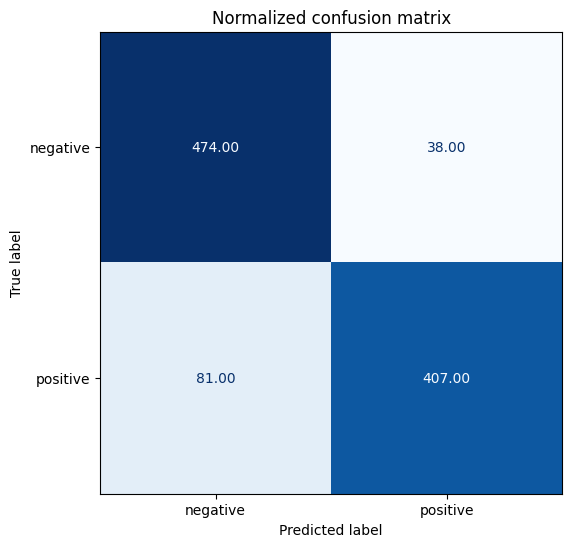

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm["confusion_matrix"],
    display_labels=["negative", "positive"],
)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)

plt.title("Normalized confusion matrix")
plt.show()

Impressive! This sentiment analysis classifier performs much better than the zero-shot setup using GPT-2.

**11. Let's build a FAQ system! Sentence transformers are powerful models that can determine how similar multiple texts are. While the transformer encoder usually outputs an embedding for each token, sentence transformers output an embedding for the whole input text, allowing us to determine if the two texts are similar based on their similarity score. Let's look at a simple example using the `sentence_transformers` library.**

This is the example provided in the book. We first load the `all-MiniLM-L6-v2` model from the Hub. We then use it to compute the embedding of two sentences using the `encode` method. Each is a tensor (vector) of 384 values. We finally compute the cosine similarity to determine how close both tensors are.

In [91]:
from sentence_transformers import SentenceTransformer, util

sentences = ["I'm happy", "I'm full of happiness"]
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Compute embedding for both lists
embedding_1 = model.encode(sentences[0], convert_to_tensor=True)
embedding_2 = model.encode(sentences[1], convert_to_tensor=True)

util.pytorch_cos_sim(embedding_1, embedding_2)

tensor([[0.6003]], device='cuda:0')

We'll write a dictionary of 5 questions and answers based on Medicare FAQ website.

In [92]:
# Data from https://faq.ssa.gov/en-US/topic/?id=CAT-01092

faq = {
    "How do I get a replacement Medicare card?": "If your Medicare card was lost, stolen, or destroyed, you can request a replacement online at Medicare.gov.",
    "How do I sign up for Medicare?": "If you already get Social Security benefits, you do not need to sign up for Medicare. We will automatically enroll you in Original Medicare (Part A and Part B) when you become eligible. We will mail you the information a few months before you become eligible.",
    "What are Medicare late enrollment penalties?": "In most cases, if you don’t sign up for Medicare when you’re first eligible, you may have to pay a higher monthly premium. Find more information at https://faq.ssa.gov/en-us/Topic/article/KA-02995",
    "Will my Medicare premiums be higher because of my higher income?": "Some people with higher income may pay a larger percentage of their monthly Medicare Part B and prescription drug costs based on their income. We call the additional amount the income-related monthly adjustment amount.",
    "What is Medicare and who can get it?": "Medicare is a health insurance program for people age 65 or older. Some younger people are eligible for Medicare including people with disabilities, permanent kidney failure and amyotrophic lateral sclerosis (Lou Gehrig’s disease or ALS). Medicare helps with the cost of health care, but it does not cover all medical expenses or the cost of most long-term care.",
}

We can use the `encode` method to compute the embedding of the 5 questions.

In [93]:
corpus_embeddings = model.encode(list(faq.values()), convert_to_tensor=True)
print(corpus_embeddings.shape)

torch.Size([5, 384])


Now, in a production setup, a user would input a question. We can compute its embedding as well.

In [94]:
user_question = "Do I need to pay more after a raise?"
query_embedding = model.encode(user_question, convert_to_tensor=True)
query_embedding.shape

torch.Size([384])

Now, using cosine similarity, we can retrieve the most similar questions from the database - that is, we retrieve the most similar questions based on the highest similarity.

Using `argsort`, we get the top 3 questions and print them.

In [95]:
import numpy as np

similarities = -util.pytorch_cos_sim(query_embedding, corpus_embeddings)[0]
top_3 = similarities.cpu().argsort()[:3]
for i, top_n in enumerate(top_3):
    print(
        f"Top {i+1} question (p={-similarities[top_n]}): {list(faq.keys())[top_n]}"
    )
    print(f"Answer: {list(faq.values())[top_n]}")

Top 1 question (p=0.35796284675598145): Will my Medicare premiums be higher because of my higher income?
Answer: Some people with higher income may pay a larger percentage of their monthly Medicare Part B and prescription drug costs based on their income. We call the additional amount the income-related monthly adjustment amount.
Top 2 question (p=0.2787759006023407): What are Medicare late enrollment penalties?
Answer: In most cases, if you don’t sign up for Medicare when you’re first eligible, you may have to pay a higher monthly premium. Find more information at https://faq.ssa.gov/en-us/Topic/article/KA-02995
Top 3 question (p=0.15840475261211395): How do I sign up for Medicare?
Answer: If you already get Social Security benefits, you do not need to sign up for Medicare. We will automatically enroll you in Original Medicare (Part A and Part B) when you become eligible. We will mail you the information a few months before you become eligible.


`sentence_transformers` also offers a convenient utility called `semantic_search` for exactly this use case.

In [96]:
similarities = util.semantic_search(
    query_embedding, corpus_embeddings, top_k=3
)[0]
for i, result in enumerate(similarities):
    corpus_id = result["corpus_id"]
    score = result["score"]
    print(f"Top {i+1} question (p={score}): {list(faq.keys())[corpus_id]}")
    print(f"Answer: {list(faq.values())[corpus_id]}")

Top 1 question (p=0.35796284675598145): Will my Medicare premiums be higher because of my higher income?
Answer: Some people with higher income may pay a larger percentage of their monthly Medicare Part B and prescription drug costs based on their income. We call the additional amount the income-related monthly adjustment amount.
Top 2 question (p=0.2787759006023407): What are Medicare late enrollment penalties?
Answer: In most cases, if you don’t sign up for Medicare when you’re first eligible, you may have to pay a higher monthly premium. Find more information at https://faq.ssa.gov/en-us/Topic/article/KA-02995
Top 3 question (p=0.15840475261211395): How do I sign up for Medicare?
Answer: If you already get Social Security benefits, you do not need to sign up for Medicare. We will automatically enroll you in Original Medicare (Part A and Part B) when you become eligible. We will mail you the information a few months before you become eligible.
